In [1]:
import torch
from torch import Tensor
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch.nn.functional as F

os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

In [2]:
seed = 42
if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_set = MNIST(root="../datasets", train=True, download=True, transform=transforms.ToTensor())
test_set = MNIST(root="../datasets", train=False, download=True, transform=transforms.ToTensor())

In [4]:
BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self) -> None:
        super(VariationalAutoEncoder, self).__init__()

        self.latent_dim = 128
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=16,
                      kernel_size=3, 
                      stride=2, 
                      padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, 
                      out_channels=32,
                      kernel_size=3, 
                      stride=2, 
                      padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, 
                      out_channels=64,
                      kernel_size=3, 
                      stride=2, 
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU()
        )

        encoder_img_shape = 64 * 4 * 4
        self.mu = nn.Linear(in_features=encoder_img_shape, out_features=self.latent_dim)
        self.var = nn.Linear(in_features=encoder_img_shape, out_features=self.latent_dim)

        self.decoder_input = nn.Linear(in_features=self.latent_dim, out_features=encoder_img_shape)

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=32,
                               kernel_size=3, 
                               stride=2, 
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=16,
                               kernel_size=3, 
                               stride=2, 
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU())
        
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, 
                               out_channels=16,
                               kernel_size=3,
                               stride=2,
                               padding=2,
                               output_padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, 
                      out_channels=1,
                      kernel_size=3, 
                      padding=0),
            nn.Tanh())
        

    def encode(self, x: Tensor) -> Tensor:
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.mu(result)
        var = self.var(result)
        return mu, var
    

    def decode(self, x: Tensor) -> Tensor:
        result = self.decoder_input(x)
        result = result.view(-1, 64, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result


    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        return eps * std + mu


    def forward(self, x: Tensor) -> Tensor:
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        decoded = self.decode(z)
        return decoded, mu, var

In [6]:
model = VariationalAutoEncoder().to(DEVICE)
# model.load_state_dict(torch.load("./best_model.pth", weights_only=True, map_location=DEVICE))

In [7]:
NUM_EPOCH = 15
LEARNING_RATE = 0.0001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0)

In [8]:
min_loss = float('inf')
train_loss = []
kld_weight = BATCH_SIZE / len(train_loader.dataset)

for epoch in range(NUM_EPOCH):

    total_loss = 0
    for img, _ in tqdm(train_loader, desc=f'Epoch: {epoch + 1}'):
        
        img = img.to(DEVICE)
        recons, mu, var = model(img)
        recons_loss = F.mse_loss(recons, img)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + var - mu ** 2 - var.exp(), dim=1), dim=0)
        loss = recons_loss + kld_loss * kld_weight
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        

    epoch_loss = total_loss / len(train_loader)
    train_loss.append(epoch_loss)

    print(f'Epoch: {epoch + 1} | Loss: {epoch_loss:.4f}')

    if epoch_loss < min_loss:
        torch.save(model.state_dict(), "./best_model.pth")
        torch.save(optimizer.state_dict(), "./optimizer_states.pth")
        min_loss = epoch_loss

Epoch: 1:   0%|          | 0/469 [00:00<?, ?it/s]

/home/atiqur/venv/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Epoch: 1 | Loss: 0.0700


Epoch: 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | Loss: 0.0403


Epoch: 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | Loss: 0.0352


Epoch: 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | Loss: 0.0324


Epoch: 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | Loss: 0.0305


Epoch: 6:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | Loss: 0.0293


Epoch: 7:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | Loss: 0.0284


Epoch: 8:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | Loss: 0.0277


Epoch: 9:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | Loss: 0.0272


Epoch: 10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | Loss: 0.0268


Epoch: 11:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | Loss: 0.0264


Epoch: 12:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | Loss: 0.0260


Epoch: 13:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | Loss: 0.0258


Epoch: 14:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | Loss: 0.0255


Epoch: 15:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | Loss: 0.0253


## Plotting the train loss curve

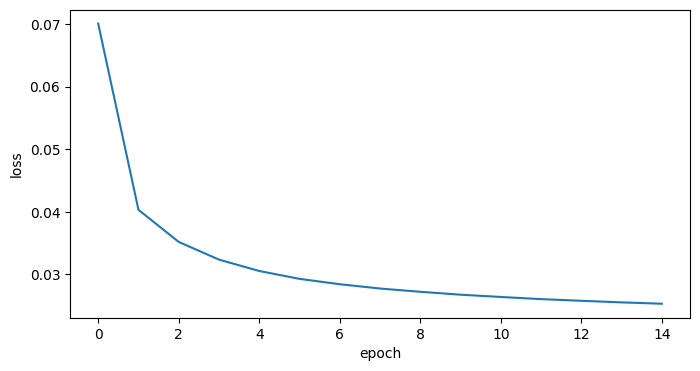

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [15]:
best_model = VariationalAutoEncoder().to(DEVICE)
best_model.load_state_dict(torch.load("./best_model.pth", weights_only=True, map_location=DEVICE))

<All keys matched successfully>

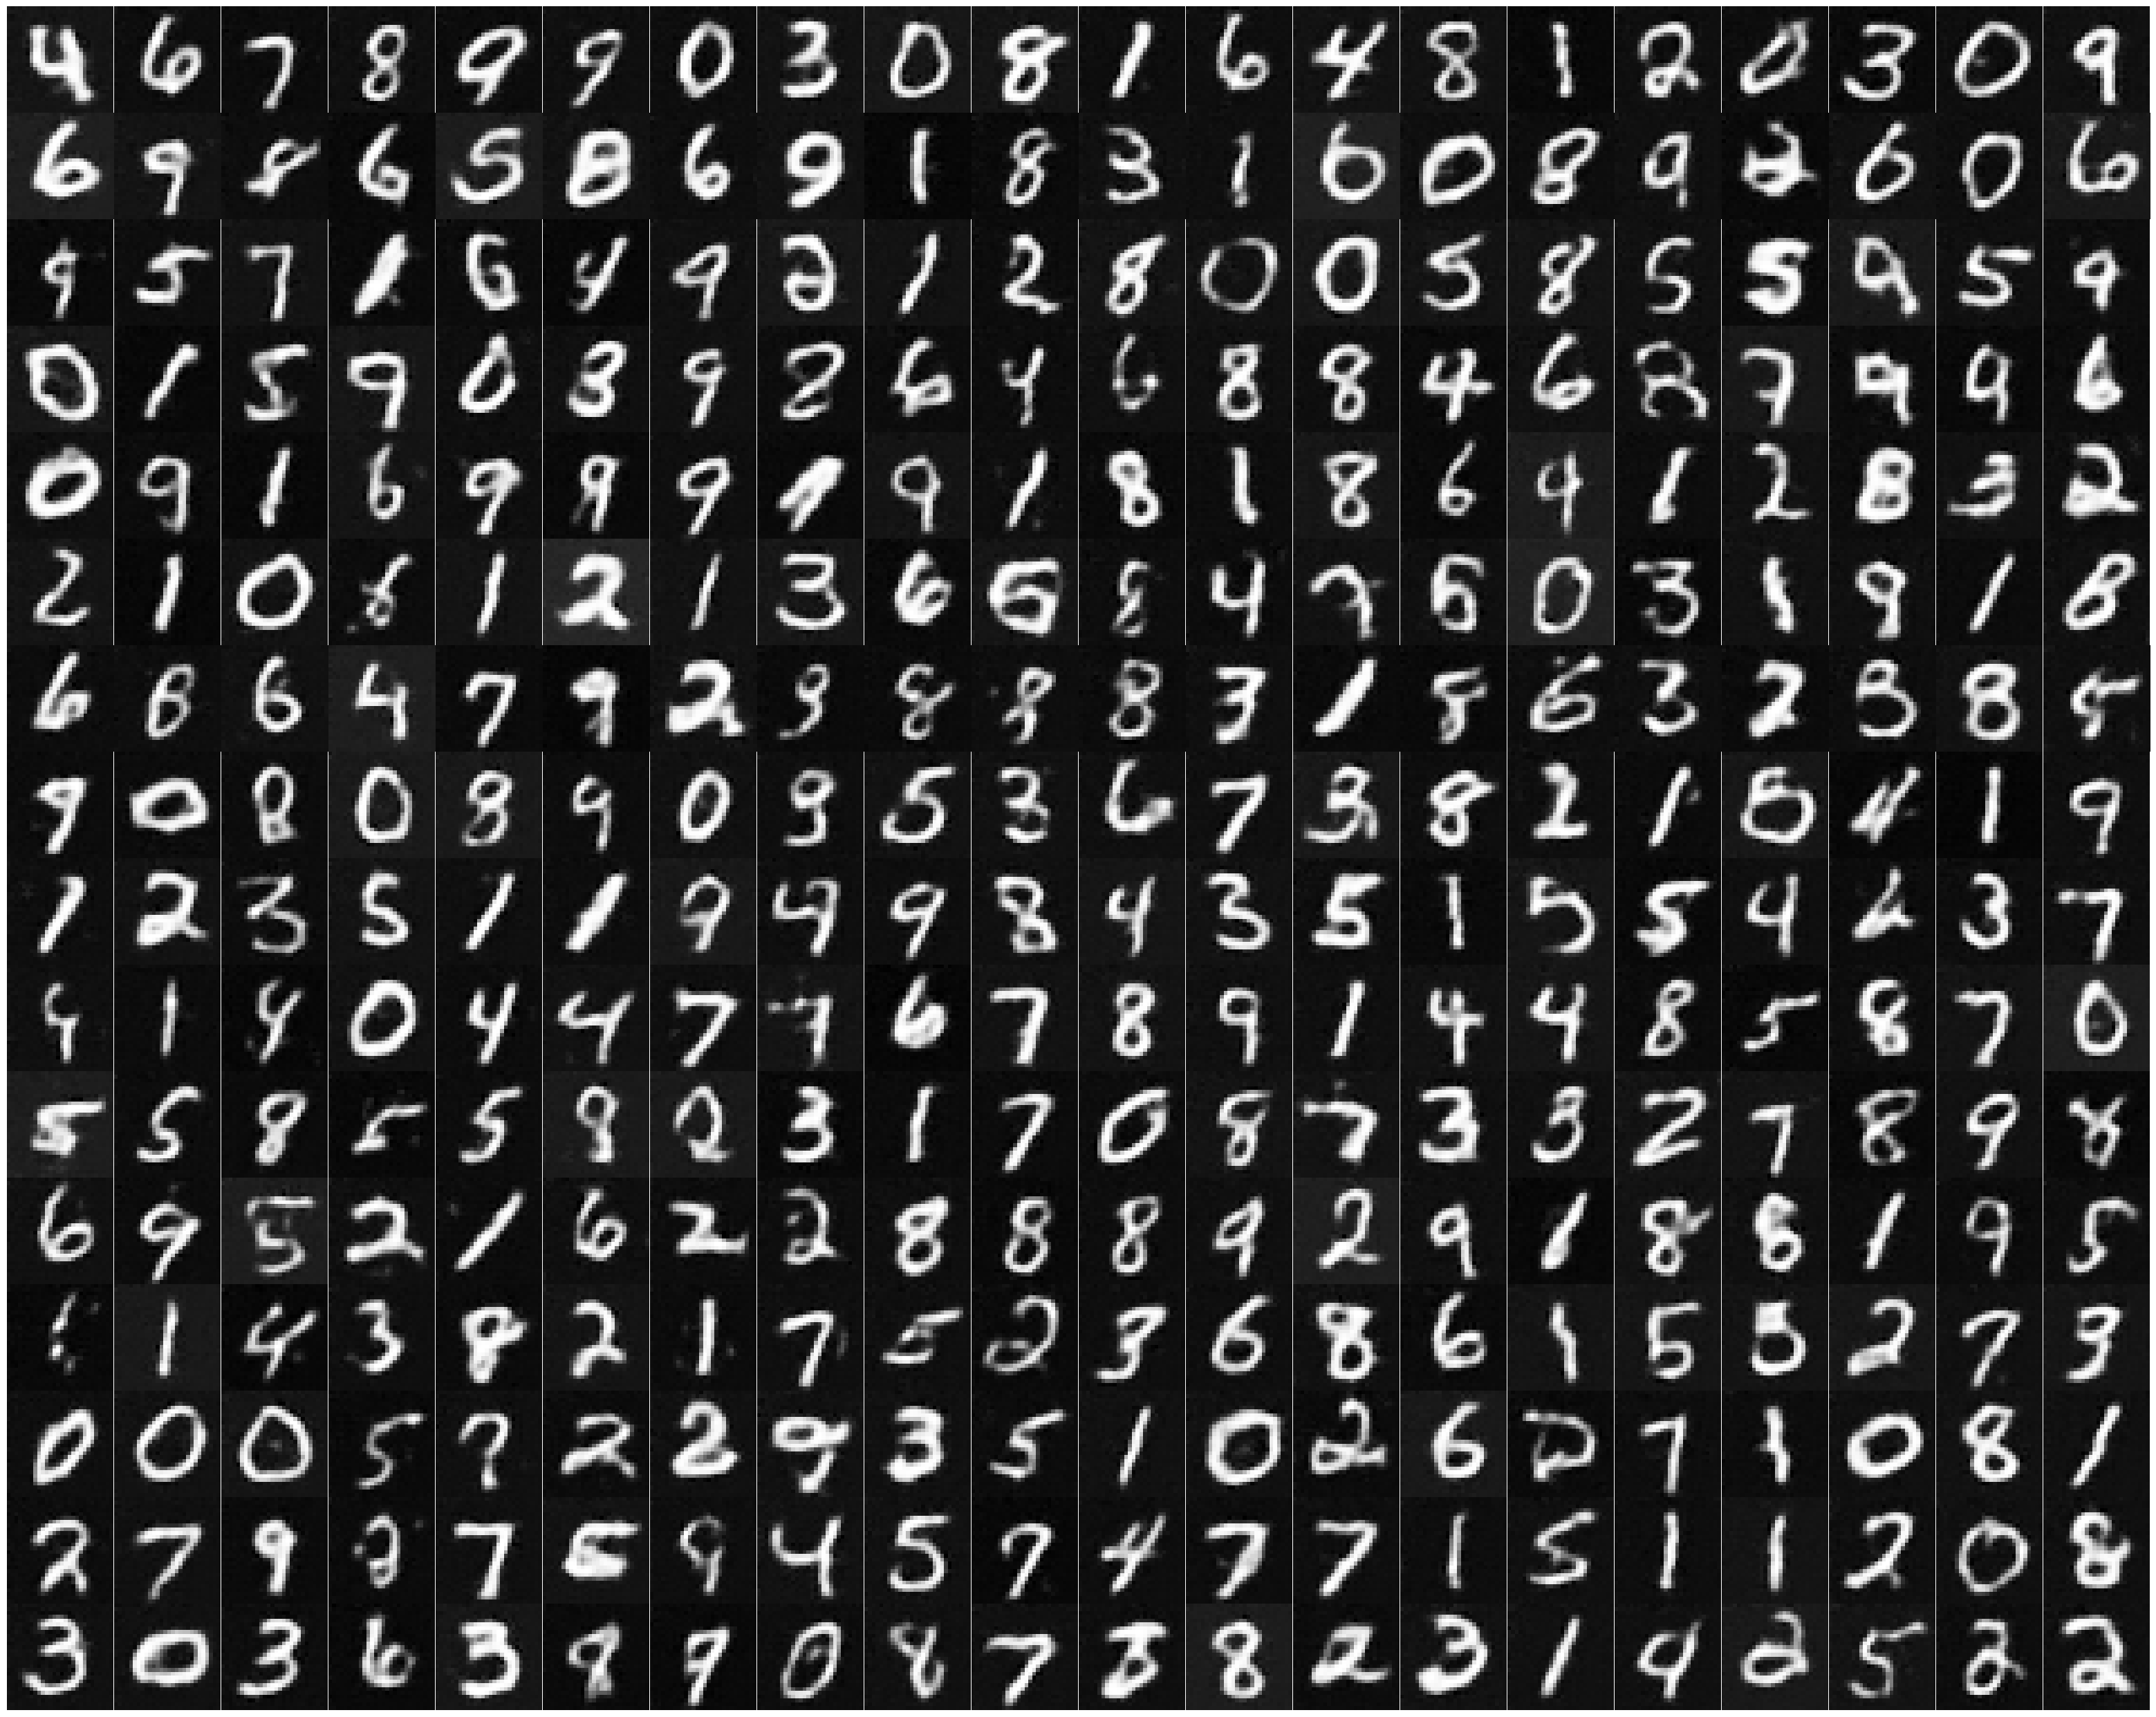

In [16]:
best_model.eval()

nrows, ncols = 16, 20
idx = np.random.choice(len(test_set), nrows * ncols,  replace=False)

with torch.no_grad():
    fig, axes = plt.subplots(nrows, ncols, figsize=(40, 32))
    for i, ax in zip(idx, axes.flatten()):
        img, _ = test_set.__getitem__(i)
        img = img.unsqueeze(0).to(DEVICE)
        out, _, _ = best_model(img)
        out = out[0].cpu().permute(1, 2, 0)
        ax.imshow(out, cmap="gray")
        ax.axis(False)

    plt.subplots_adjust(wspace=0.00, hspace=0.00)
    plt.show()

In [17]:
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = images.to(DEVICE)
        _, mu, _ = best_model(images)
        latent_vectors.extend(mu.cpu())
        labels.extend(targets.numpy())

  0%|          | 0/79 [00:00<?, ?it/s]

In [18]:
latent_2d = TSNE(n_components=2).fit_transform(np.array(latent_vectors))

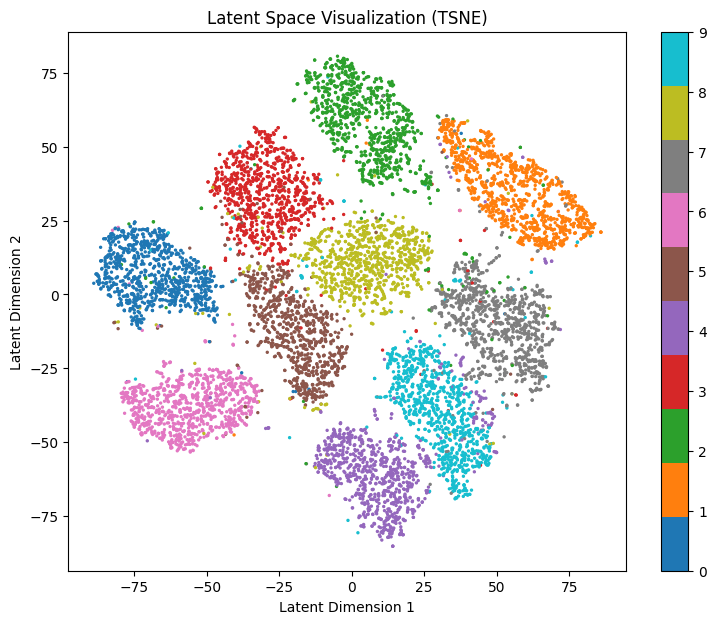

In [19]:
plt.figure(figsize=(9, 7))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=2)
plt.colorbar()
plt.title('Latent Space Visualization (TSNE)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()